In [1]:
import yaml
import sys
import numpy as np
import hashlib
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import math
from scipy import stats
from datetime import datetime, timedelta


def getAgentHash(agent, agentHashRange) :
    hashret = int(hashlib.sha1(agent.encode('utf-8')).hexdigest(), 16) % agentHashRange

    return str(hashret)

def loadConfig():
    with open(sys.argv[1], "r") as ymlfile:
        cfg = yaml.load(ymlfile)
    return cfg

def getHash(fullURI, queryHashRange):
    hashret = 0

    #Handles cases with no '/'
    if(fullURI.find('/') == -1) :
        fullURI = '/' + fullURI

    uri = fullURI.split('?', 1)[0]

    if (len(uri.rsplit('/', 1)) > 1) :
        request = uri.rsplit('/', 1)[1]
    else :
        request = ''

    if (len(fullURI.split('?', 1)) > 1) :
        request = request + '?' + fullURI.split('?', 1)[1]
    else :
        request = request

    hashret = int(hashlib.sha1(request.encode('utf-8')).hexdigest(), 16) % queryHashRange
    uri = uri.rsplit('/', 1)[0]

    return str(hashret)

def getURI(fullURI):
    uri = fullURI.split('?', 1)[0]
    uri = uri.rsplit('/', 1)[0]


    if uri == '' :
        return '<EMPTY>'
    else :
        return str(uri)

def converttodatetime(x, seqlen):
    # if len(x)< 20:
    if len(x)< seqlen:    # add
        x += '.000'
    return datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S.%f")

#TimeDif 0 Padding
# Start = 14
# End = 15
def getTimeClass(time_dif):
    time = 0
    if time_dif == 0.0:
        time = 0
    elif time_dif < 0.001 :
        time = 1
    elif time_dif < 0.05 :
        time = 2
    elif time_dif < 0.1 :
        time = 3
    elif time_dif < 1 :
        time = 4
    elif time_dif < 15 :
        time = 5
    elif time_dif < 180 :
        time = 6
    elif time_dif > 300 :
        time = 7

    return str(time)

#Source IP  Dest IP Time    Packet Len  IP Flags    TCP Len TCP Ack TCP Flags   TCP Window Size UDP Len ICMP Type   Protocols   Highest Layer(Protocol) Info
def prepDataFrame(df, agentHashRange, queryHashRange) :
    #create a deepcopy of the original df
    df_temp = df.copy()
    if type(df_temp['Absolute Time'].iloc[0]) == str:
        df_temp['Absolute Time'] = df_temp['Absolute Time'].apply(lambda x: converttodatetime(x, config['SEQUENCELENGTH'])) # add

    #converting type of status
    df_temp = df_temp.astype({'Source IP' : 'str'})
    df_temp = df_temp.astype({'Dest IP' : 'str'})
    # df_temp = df_temp.astype({'Relative Time' : 'str'})
    df_temp = df_temp.astype({'Packet Len': 'str'})
    df_temp = df_temp.astype({'IP Flags' : 'str'})
    df_temp = df_temp.astype({'TCP Len' : 'str'})
    df_temp = df_temp.astype({'TCP Flags' : 'str'})
    df_temp = df_temp.astype({'TCP Window Size': 'str'})
    df_temp = df_temp.astype({'Protocols': 'str'})
    df_temp = df_temp.astype({'Highest Layer(Protocol)': 'str'})
    df_temp = df_temp.astype({'Info' : 'str'})

    ##TCP ACK Feature Engineering
    tcpack = np.array(df_temp['TCP Ack'])
    bin_edges = stats.mstats.mquantiles(tcpack, np.arange(0,1,0.01)[1:])

    df_temp.loc[df_temp['TCP Ack'] <= bin_edges[int(0)], 'new TCP Ack'] = int(0)

    for i in range(len(bin_edges)-1):
        df_temp.loc[(bin_edges[int(i)] < df_temp['TCP Ack']) & (df_temp['TCP Ack'] <= bin_edges[int(i+1)]), 'new TCP Ack'] = int(i+1)

    df_temp.loc[df_temp['TCP Ack'] > bin_edges[-1], 'new TCP Ack'] = int(len(bin_edges))
    df_temp['new TCP Ack'] = df_temp['new TCP Ack'].astype('str')

    #Relative Time Feature Engineering
    # reltime = np.array(df['Relative Time'])
    # round_reltime = np.around(reltime, decimals=0, out=None)
    # df_temp.insert(1, "new Relative Time", round_reltime, True)
    # df_temp['new Relative Time'] = df_temp['new Relative Time'].astype('str')

    #calculate the difference between requests from a specific user
    df_temp['time_diff'] = df_temp.groupby('Source IP')['Absolute Time'].diff()

    #Maybe can remove this (DOUBLE CHECK)
    df_temp['time_diff_group'] = df_temp['time_diff'].apply(lambda x: getTimeClass(x.total_seconds()))

    #Calculate the Combined Input of URI Hash Status Time
    df_temp['Input'] = df_temp['Packet Len'] + '<JOIN>' + df_temp['IP Flags'] + '<JOIN>' + df_temp['TCP Len'] + '<JOIN>' + df_temp['new TCP Ack'] + '<JOIN>' + df_temp['TCP Flags'] + '<JOIN>' + df_temp['TCP Window Size'] + '<JOIN>' + df_temp['Highest Layer(Protocol)']

    return df_temp

def getSignificantRequest(dataframe, hashThreshold) :
    freq = dataframe['Input'].value_counts(normalize=True)

    ret = []

    index = freq.index
    for i in range(len(freq)):
        if freq[i] > hashThreshold :
            ret.append(index[i])

    return ret

# def keepOrHash(uri, sig, inputHashRange) :
#     if uri in sig :
#         return uri
#     else :
#         return str(int(hashlib.sha1(uri.encode('utf-8')).hexdigest(), 16) % inputHashRange)
def keepOrHash(uri, sig, inputHashRange) :
#     if uri in sig :
#         return uri
#     else :
    return str(int(hashlib.sha1(uri.encode('utf-8')).hexdigest(), 16) % inputHashRange)

def sequentializeDataFrame(df, sig, inputHashRange, seqlen): # add
    #create a deepcopy of the original df
    df_temp = df.copy()
    if type(df_temp['Absolute Time'].iloc[0]) == str:
        df_temp['Absolute Time'] = df_temp['Absolute Time'].apply(lambda x: converttodatetime(x, config['SEQUENCELENGTH'])) # add
    #converting type of status
    df_temp = df_temp.astype({'Source IP' : 'str'})
    df_temp = df_temp.astype({'Dest IP' : 'str'})
    # df_temp = df_temp.astype({'Relative Time' : 'str'})
    df_temp = df_temp.astype({'Packet Len': 'str'})
    df_temp = df_temp.astype({'IP Flags' : 'str'})
    df_temp = df_temp.astype({'TCP Len' : 'str'})
    df_temp = df_temp.astype({'TCP Ack' : 'str'})
    df_temp = df_temp.astype({'TCP Flags' : 'str'})
    df_temp = df_temp.astype({'TCP Window Size': 'str'})
    df_temp = df_temp.astype({'Protocols': 'str'})
    df_temp = df_temp.astype({'Highest Layer(Protocol)': 'str'})
    df_temp = df_temp.astype({'Info' : 'str'})
    df_temp = df_temp.astype({'Input': 'str'})

    #Uncomment if you want to hash the Input
    df_temp['Input'] = df_temp['Input'].apply(lambda x: keepOrHash(x, sig, inputHashRange))

    #create groups based on 1 min interval
    df_temp['groups'] = df_temp.groupby('Source IP')['time_diff'].apply(lambda x: x.gt(pd.Timedelta(1, 'm')).cumsum())
    df_temp['time_diff'] = df_temp['time_diff'].apply(lambda x: getTimeClass(x.total_seconds()))
    #grouping in sequences of 20 length
    df_temp['group_len'] = df_temp.groupby(['Source IP', 'Dest IP', 'groups'])['Absolute Time'].rank(method = 'first')
    # df_temp['group_len'] = df_temp['group_len'].apply(lambda x: math.ceil(x/20))
    df_temp['group_len'] = df_temp['group_len'].apply(lambda x: math.ceil(x/seqlen)) # add

    #create groups based on "remote_addr" and "groups"
    df_temp = df_temp.groupby(['Source IP', 'Dest IP', 'groups', 'group_len'])

    #aggregation
    sr = df_temp['Protocols', 'Info'].agg(lambda x: "<SEP>".join(x))
    sr['Input'] = df_temp['Input'].agg(lambda x: "<SEP>".join(x))
    sr.reset_index(inplace=True)
    #converting to dataframe
    #sr = sr.to_frame()
    sr = sr.drop(columns = ['groups', 'group_len'])
    return sr

def getCountryAgentPair(x, y):
    agent = x.split('<SEP>')[0]
    country = y.split('<SEP>')[0]

    return str(country) + '<JOIN>' + str(agent)

def getFirstOnly(y):
    country = y.split('<SEP>')[0]

    return str(country)


#Remove request if Remote Addresses (IP) appear 10 or less times
#Because the data is not in chronological form, sort by timestamp to get in chronological form
def filterAndSort(df) :
    df = df.sort_values(by=['Absolute Time'])
    before = len(df)
    df = df.groupby('Source IP').filter(lambda x: len(x) > 10)
    after = len(df)
    df = df.reset_index()

    print("Before = {}, After = {}".format(before, after))

    return df

#Split dataframe into 5s interval
def getIntervals(df) :
    ret = []
    S = pd.to_datetime(df['Absolute Time'])
    timebins = (S - S[0]).astype('timedelta64[m]')
    timebins = timebins.tolist()
    timebins = [math.floor(time/1) for time in timebins]
    timebins = [pd.Series(timebins)]

    for i, g in df.groupby(timebins):
        ret.append(g.reset_index(drop=True))

    return ret


In [2]:
print("*****     Starting Preprocessing     ******")
# config = loadConfig()
with open('light_config.yaml', "r") as ymlfile:
    config = yaml.load(ymlfile)

*****     Starting Preprocessing     ******


/home/wesleyjtann/miniconda3/envs/ddosgen/lib/python3.6/site-packages/ipykernel_launcher.py:4: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  after removing the cwd from sys.path.


In [4]:
dfA = pd.read_csv(config['datapath']['a'], parse_dates=['Absolute Time'])
dfN1 = pd.read_csv(config['datapath']['n1'], parse_dates=['Absolute Time'])

# #load N2
# dfN2 = pd.read_csv(config['datapath']['n2'], parse_dates=['Absolute Time'])

#Remove request if Remote Addresses (IP) appear 10 or less times
#Because the data is not in chronological form, sort by timestamp to get in chronological form
dfA = filterAndSort(dfA)
dfN1 = filterAndSort(dfN1)
# dfN2 = filterAndSort(dfN2)

Before = 20533086, After = 20531528
Before = 593871, After = 593462


In [5]:
#Prepares A1 and N1 for sequentializing
df_normal = prepDataFrame(dfN1, config['variablesHash']['agentHashRange'], config['variablesHash']['queryHashRange'])
# df_normal2 = prepDataFrame(dfN2, config['variablesHash']['agentHashRange'], config['variablesHash']['queryHashRange'])
significantNormal = getSignificantRequest(df_normal, config['variablesHash']['inputHashThreshold'])

In [6]:
df_normal.head()

,index,Unnamed: 0,Pkt #,Absolute Time,Source IP,Dest IP,Source Port,Dest Port,Relative Time,Packet Len,...,TCP Ack,TCP Flags,TCP Window Size,Protocols,Highest Layer(Protocol),Info,new TCP Ack,time_diff,time_diff_group,Input
0,0,0,0,2007-08-04 20:49:36.487629,202.1.175.252,71.126.222.64,0.0,0.0,0.000000,60,...,0.0,0,0.0,raw:ip:icmp,ICMP,"Echo (ping) request id=0xce1d, seq=1280/5, tt...",0.0,NaT,0,60<JOIN>0x00000000<JOIN>0.0<JOIN>0.0<JOIN>0<JO...
1,1,1,1,2007-08-04 20:49:36.489552,192.120.148.227,71.126.222.64,0.0,0.0,0.001923,60,...,0.0,0,0.0,raw:ip:icmp,ICMP,"Echo (ping) request id=0x0200, seq=1280/5, tt...",0.0,NaT,0,60<JOIN>0x00000000<JOIN>0.0<JOIN>0.0<JOIN>0<JO...
2,2,2,2,2007-08-04 20:49:36.491812,51.81.166.201,71.126.222.64,0.0,0.0,0.004183,60,...,0.0,0,0.0,raw:ip:icmp,ICMP,"Echo (ping) request id=0xef41, seq=1280/5, tt...",0.0,NaT,0,60<JOIN>0x00000000<JOIN>0.0<JOIN>0.0<JOIN>0<JO...
3,3,3,3,2007-08-04 20:49:36.492189,192.95.27.190,71.126.222.64,0.0,0.0,0.004560,60,...,0.0,0,0.0,raw:ip:icmp,ICMP,"Echo (ping) request id=0xc495, seq=1280/5, tt...",0.0,NaT,0,60<JOIN>0x00000000<JOIN>0.0<JOIN>0.0<JOIN>0<JO...
4,4,4,4,2007-08-04 20:49:36.496475,51.173.229.255,71.126.222.64,0.0,0.0,0.008846,60,...,0.0,0,0.0,raw:ip:icmp,ICMP,"Echo (ping) request id=0x0200, seq=1280/5, tt...",0.0,NaT,0,60<JOIN>0x00000000<JOIN>0.0<JOIN>0.0<JOIN>0<JO...


In [7]:
df_normal.nunique()

index                      593462
Unnamed: 0                 166439
Pkt #                      166439
Absolute Time              593462
Source IP                     125
Dest IP                       190
Source Port                  5573
Dest Port                    4523
Relative Time              592964
Packet Len                   1059
IP Flags                        2
TCP Len                      1051
TCP Ack                      7598
TCP Flags                       9
TCP Window Size              1614
Protocols                       4
Highest Layer(Protocol)         3
Info                        98743
new TCP Ack                    15
time_diff                   63709
time_diff_group                 8
Input                        7789
dtype: int64

Top 10:  0.8103113594467717


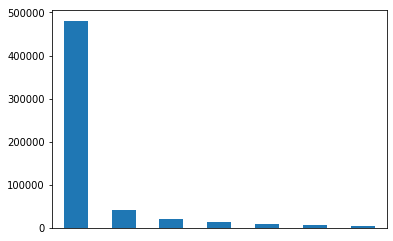

In [8]:
feature = 'Packet Len' 
num_feature = df_normal[feature].nunique()
percent_plot = 0.007
range_plot = int(num_feature*percent_plot)
# print(df_normal[feature].value_counts())

print("Top 10: ", sum(df_normal[feature].value_counts().nlargest(1)) / len(df_normal[feature]))
df_normal[feature].value_counts()[:range_plot].plot(kind='bar').get_xaxis().set_visible(False)

Top 10:  1.0


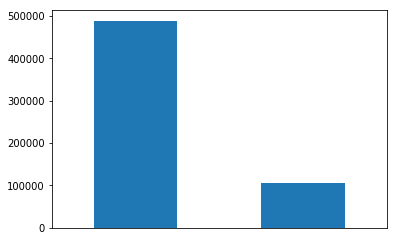

In [9]:
feature = 'IP Flags' 
num_feature = df_normal[feature].nunique()
percent_plot = 1
range_plot = int(num_feature*percent_plot)
# print(df_normal[feature].value_counts())

print("Top 10: ", sum(df_normal[feature].value_counts().nlargest(10)) / len(df_normal[feature]))
df_normal[feature].value_counts()[:range_plot].plot(kind='bar').get_xaxis().set_visible(False)

Top 10:  0.9758653460541703


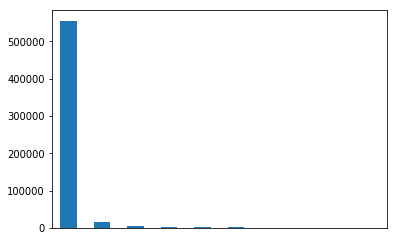

In [10]:
feature = 'TCP Len' 
num_feature = df_normal[feature].nunique()
percent_plot = 0.01
range_plot = int(num_feature*percent_plot)
# print(df_normal[feature].value_counts())

print("Top 10: ", sum(df_normal[feature].value_counts().nlargest(10)) / len(df_normal[feature]))
df_normal[feature].value_counts()[:range_plot].plot(kind='bar').get_xaxis().set_visible(False)

In [12]:
feature = 'TCP Ack' 
num_feature = df_normal[feature].nunique()
percent_plot = 1
range_plot = int(num_feature*percent_plot)
# print(df_normal[feature].value_counts())

print("Top 10: ", sum(df_normal[feature].value_counts().nlargest(10)) / len(df_normal[feature]))
df_normal[feature].value_counts()[:20].plot(kind='bar').get_xaxis().set_visible(False)

Top 10:  0.8859337244844657


KeyError: 20.0

Top 10:  1.0


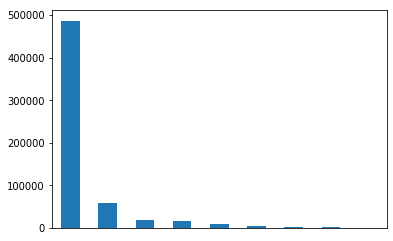

In [13]:
feature = 'TCP Flags'
num_feature = df_normal[feature].nunique()
percent_plot = 1
range_plot = int(num_feature*percent_plot)
# print(df_normal[feature].value_counts())

print("Top 10: ", sum(df_normal[feature].value_counts().nlargest(10)) / len(df_normal[feature]))
df_normal[feature].value_counts()[:range_plot].plot(kind='bar').get_xaxis().set_visible(False)

Top 10:  0.9117416110888313


0.0        487351
5840.0      17586
64512.0      9737
65535.0      6563
8736.0       4904
Name: TCP Window Size, dtype: int64

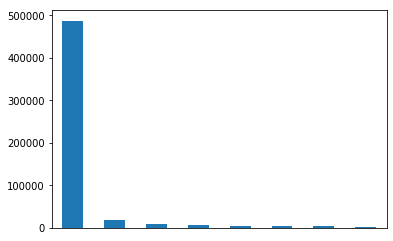

In [24]:
feature = 'TCP Window Size'
num_feature = df_normal[feature].nunique()
percent_plot = 0.005
range_plot = int(num_feature*percent_plot)
# print(df_normal[feature].value_counts())

print("Top 10: ", sum(df_normal[feature].value_counts().nlargest(10)) / len(df_normal[feature]))
df_normal[feature].value_counts()[:range_plot].plot(kind='bar').get_xaxis().set_visible(False)
df_normal[feature].value_counts()[:5]

Top 10:  1.0


raw:ip:icmp       474183
raw:ip:tcp        106706
raw:ip:icmp:ip     12570
raw:ip:udp:ntp         3
Name: Protocols, dtype: int64

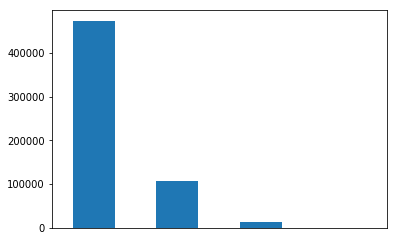

In [27]:
feature = 'Protocols'
num_feature = df_normal[feature].nunique()
percent_plot = 1
range_plot = int(num_feature*percent_plot)
# print(df_normal[feature].value_counts())

print("Top 10: ", sum(df_normal[feature].value_counts().nlargest(10)) / len(df_normal[feature]))
df_normal[feature].value_counts()[:range_plot].plot(kind='bar').get_xaxis().set_visible(False)
df_normal[feature].value_counts()[:5]

In [34]:
3 / (474183+106706+12570+3)

593462

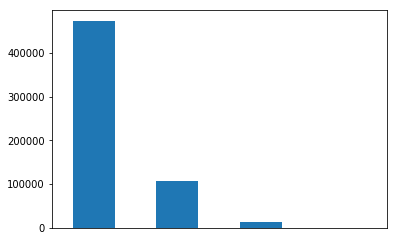

In [28]:
import matplotlib.pyplot as plt
plt.figure()
df_normal[feature].value_counts()[:range_plot].plot(kind='bar').get_xaxis().set_visible(False)
plt.savefig("./caida_feature_protocols.png",bbox_inches="tight")

Top 10:  1.0


ICMP    486753
TCP     106706
NTP          3
Name: Highest Layer(Protocol), dtype: int64

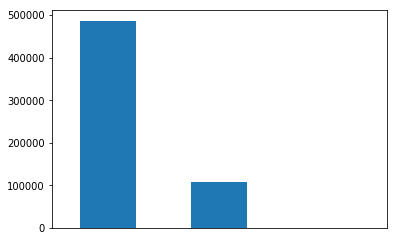

In [25]:
feature = 'Highest Layer(Protocol)'
num_feature = df_normal[feature].nunique()
percent_plot = 1
range_plot = int(num_feature*percent_plot)
# print(df_normal[feature].value_counts())

print("Top 10: ", sum(df_normal[feature].value_counts().nlargest(10)) / len(df_normal[feature]))
df_normal[feature].value_counts()[:range_plot].plot(kind='bar').get_xaxis().set_visible(False)
df_normal[feature].value_counts()[:5]

Top 10:  0.6603472505400514


Echo (ping) request  id=0x0200, seq=1280/5, ttl=208    90262
Name: Info, dtype: int64

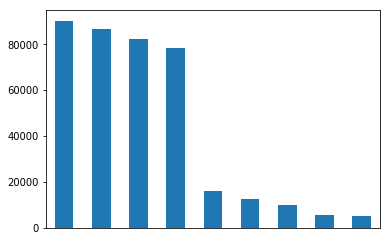

In [21]:
feature = 'Info'
num_feature = df_normal[feature].nunique()
percent_plot = 0.0001
range_plot = int(num_feature*percent_plot)
# print(df_normal[feature].value_counts())

print("Top 10: ", sum(df_normal[feature].value_counts().nlargest(10)) / len(df_normal[feature]))
df_normal[feature].value_counts()[:range_plot].plot(kind='bar').get_xaxis().set_visible(False)
df_normal[feature].value_counts()[:1]

In [ ]:
feature = 'new TCP Ack'
num_feature = df_normal[feature].nunique()
percent_plot = 1
range_plot = int(num_feature*percent_plot)
# print(df_normal[feature].value_counts())

print("Top 10: ", sum(df_normal[feature].value_counts().nlargest(10)) / len(df_normal[feature]))
df_normal[feature].value_counts()[:range_plot].plot(kind='bar').get_xaxis().set_visible(False)

### Feature Selection

### Hashing the inputs

In [8]:
df = df_normal; sig=significantNormal; inputHashRange=config['variablesHash']['inputHashRange']; seqlen=config['SEQUENCELENGTH']

In [9]:
#create a deepcopy of the original df
df_temp = df.copy()
if type(df_temp['Absolute Time'].iloc[0]) == str:
    df_temp['Absolute Time'] = df_temp['Absolute Time'].apply(lambda x: converttodatetime(x,config['SEQUENCELENGTH'])) # add
#converting type of status
df_temp = df_temp.astype({'Source IP' : 'str'})
df_temp = df_temp.astype({'Dest IP' : 'str'})
# df_temp = df_temp.astype({'Relative Time' : 'str'})
df_temp = df_temp.astype({'Packet Len': 'str'})
df_temp = df_temp.astype({'IP Flags' : 'str'})
df_temp = df_temp.astype({'TCP Len' : 'str'})
df_temp = df_temp.astype({'TCP Ack' : 'str'})
df_temp = df_temp.astype({'TCP Flags' : 'str'})
df_temp = df_temp.astype({'TCP Window Size': 'str'})
df_temp = df_temp.astype({'Protocols': 'str'})
df_temp = df_temp.astype({'Highest Layer(Protocol)': 'str'})
df_temp = df_temp.astype({'Info' : 'str'})
df_temp = df_temp.astype({'Input': 'str'})

#Uncomment if you want to hash the Input
df_temp['Input'] = df_temp['Input'].apply(lambda x: keepOrHash(x, significantNormal, config['variablesHash']['inputHashRange']))

In [10]:
np.sort(df_temp['Input'].astype(int).unique())

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [11]:
df_temp["Label"] = 0

### Feature conditions
feature_cond = 'Packet Len'
top_n = 2 #3

df_normal[feature_cond].nunique()
print("value count of features: ", df_normal[feature_cond].value_counts()[:top_n])
topn_features = df_normal[feature_cond].value_counts().index.tolist()[:top_n]

topn_features

value count of features:  60      480889
52       40898
1500     19394
Name: Packet Len, dtype: int64


['60', '52', '1500']

In [22]:
df_temp.loc[df_temp[feature_cond] == topn_features[0], 'Label'] = 1
df_temp.loc[df_temp[feature_cond] == topn_features[1], 'Label'] = 2
# df_temp.loc[df_temp[feature_cond] == topn_features[2], 'Label'] = 3

In [23]:
df_temp['Input'] = df_temp['Input'].astype(int)
df_temp['Input'][0]

2

In [24]:
df_temp = df_temp.sort_values('Input')

In [25]:
df_temp['Label'].value_counts()
# df_temp.head()

1    480889
0     71675
2     40898
Name: Label, dtype: int64

In [28]:
# # group by median
# df_temp.groupby(['Input']).median()['Label'] #.to_csv('packetlen_cond.csv',index=False)

# group by mode and save
df_temp.groupby(['Input']).agg(lambda x:x.value_counts().index[0])['Label'].to_csv('packetlen_cond.csv',index=False)

/home/wesleyjtann/miniconda3/envs/ddosgen/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """


In [27]:
df_temp.groupby(['Input']).agg(lambda x:x.value_counts().index[0])['Label']

Input
0      0
1      0
2      1
3      0
4      2
5      0
6      2
7      2
8      0
9      2
10     0
11     0
12     0
13     0
14     2
15     0
16     0
17     2
18     0
19     2
20     0
21     0
22     0
23     0
24     0
25     0
26     0
27     0
28     0
29     0
      ..
220    0
221    0
222    2
223    0
224    0
225    2
226    2
227    0
228    0
229    0
230    0
231    0
232    0
233    2
234    0
235    0
236    0
237    0
238    0
239    0
240    0
241    2
242    0
243    0
244    0
245    0
246    0
247    0
248    0
249    0
Name: Label, Length: 250, dtype: int64